In [1]:
import os
import io
import ast
import boto3
import sagemaker
import numpy as np
import pandas as pd

from sagemaker.pytorch import PyTorch

from ibov.utils import load_config
from ibov.deploy import get_deploy_config, build_endpoint, kill_endpoint

### Loading Configs

In [2]:
# Load config dict
config = load_config()

In [3]:
role = config.get("sagemaker").get("role")
prefix = config.get("sagemaker").get("bucket_prefx")
data_dir = config.get("data").get("dir")
region = config.get("sagemaker").get("region")

In [4]:
dropout = config.get("model").get("dropout")
window = config.get("feature").get("window")
hidden_layer = config.get("model").get("hidden_layer")
lr = config.get("model").get("lr")
seed = config.get("model").get("seed")
epochs = config.get("model").get("epochs")

### Upload Data

In [114]:
session = sagemaker.Session(boto_session=boto3.session.Session(region_name=region))
bucket = session.default_bucket()

In [115]:
input_data = session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
input_config = session.upload_data(path="config.json", bucket=bucket, key_prefix=prefix)

### Train Model

In [116]:
estimator = PyTorch(entry_point="train.py", 
                    source_dir="ibov", 
                    py_version="py3",
                    role=role, 
                    framework_version='0.4.0',
                    instance_count=1, 
                    instance_type='ml.p2.xlarge',
                    hyperparameters = {
                        "batch-size": 50,
                        "epochs": epochs,
                        "seed": seed,
                        "input-layer": window,
                        "hidden-layer": hidden_layer,
                        "dropout": dropout        
                    })

In [117]:
estimator.fit({'train': input_data, "config": input_config})

2021-01-17 19:46:07 Starting - Starting the training job...
2021-01-17 19:46:32 Starting - Launching requested ML instancesProfilerReport-1610912764: InProgress
...
2021-01-17 19:47:21 Starting - Preparing the instances for training......
2021-01-17 19:48:47 Downloading - Downloading input data...
2021-01-17 19:49:17 Training - Downloading the training image..
2021-01-17 19:50:06 Uploading - Uploading generated training modelbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-17 19:49:51,137 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-01-17 19:49:51,165 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-17 19:49:51,378 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-17 19:49:51,662 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-01-17 19:49:51


2021-01-17 19:50:35 Completed - Training job completed
ProfilerReport-1610912764: NoIssuesFound
Training seconds: 86
Billable seconds: 86


In [118]:
estimator.latest_training_job.job_name

'sagemaker-pytorch-2021-01-17-19-45-55-738'

### Model Deployment

In [119]:
config = load_config()

In [120]:
deploy_config = get_deploy_config(config)

In [121]:
build_endpoint(deploy_config)

({'ModelArn': 'arn:aws:sagemaker:us-east-1:977053370764:model/first-fly2',
  'ResponseMetadata': {'RequestId': '8d19379c-eaed-40b0-998a-a7c7c8e6986b',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amzn-requestid': '8d19379c-eaed-40b0-998a-a7c7c8e6986b',
    'content-type': 'application/x-amz-json-1.1',
    'content-length': '72',
    'date': 'Sun, 17 Jan 2021 19:51:46 GMT'},
   'RetryAttempts': 0}},
 {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:977053370764:endpoint-config/first-fly2',
  'ResponseMetadata': {'RequestId': 'ef0943cd-b568-4c72-802e-6f4834802323',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amzn-requestid': 'ef0943cd-b568-4c72-802e-6f4834802323',
    'content-type': 'application/x-amz-json-1.1',
    'content-length': '91',
    'date': 'Sun, 17 Jan 2021 19:51:46 GMT'},
   'RetryAttempts': 0}},
 {'EndpointArn': 'arn:aws:sagemaker:us-east-1:977053370764:endpoint/first-fly2',
  'ResponseMetadata': {'RequestId': '88611ed9-0dec-4d98-9eb5-4effdc9e67fb',
   'HTTPStatus

### Scoring

In [7]:
import boto3
import io

In [8]:
def get_data(config):
    
    bucket = config.get("scoring").get("bucket")
    key = config.get("scoring").get("key")
    
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = obj['Body'].read()
    
    return df 

In [9]:
dados = get_data(config)

In [10]:
asd = pd.read_csv(io.BytesIO(dados))

In [11]:
from datetime import datetime, timedelta

In [29]:
asd

,symbol,date,low,high,open,close,volume,adjclose
0,^BVSP,2021-01-06,118917.0,120924.0,119377.0,119851.0,11638200.0,119851.0
1,^BVSP,2021-01-07,119101.0,121983.0,119103.0,121956.0,11774800.0,121956.0
2,^BVSP,2021-01-08,122386.0,125324.0,122387.0,125077.0,11085800.0,125077.0
3,^BVSP,2021-01-11,122506.0,125075.0,125075.0,122807.0,9537600.0,122807.0
4,^BVSP,2021-01-12,123227.0,124584.0,123255.0,123998.0,8949000.0,123998.0
5,^BVSP,2021-01-13,121016.0,124032.0,123996.0,122040.0,10291500.0,122040.0
6,^BVSP,2021-01-14,121947.0,123896.0,121947.0,123481.0,8974400.0,123481.0
7,^BVSP,2021-01-15,120374.0,123472.0,123472.0,120502.0,9387600.0,120502.0


In [32]:
tomm = datetime.strftime(datetime.strptime(asd["date"][len(asd)-1], "%Y-%m-%d") + timedelta(days=1), "%Y-%m-%d")

In [13]:
resposta = '[70986.03125]'

In [ ]:
import 

In [125]:
config.get("deploy").get("codename")

'first-fly2'

In [126]:
runtime = boto3.client("sagemaker-runtime")

response = runtime.invoke_endpoint(EndpointName=config.get("deploy").get("codename"),
                       Body=dados,
                       ContentType='text/csv',
                       Accept='Accept')

In [127]:
resposta = response["Body"].read().decode("utf-8")

In [18]:
prediction = ast.literal_eval(resposta)[0]

In [1]:
prediction

NameError: name 'prediction' is not defined

In [61]:
dados_graph = asd[["date", "close"]]
dados_graph[["type"]] = "true"
dados_graph.loc[len(dados_graph)] = [tomm, prediction, "pred"]
dados_graph['color']= np.where( type=="true" , "#9b59b6", "#3498db")

In [62]:
dados_graph

,date,close,type,color
0,2021-01-06,119851.00000,true,#3498db
1,2021-01-07,121956.00000,true,#3498db
2,2021-01-08,125077.00000,true,#3498db
3,2021-01-11,122807.00000,true,#3498db
4,2021-01-12,123998.00000,true,#3498db
5,2021-01-13,122040.00000,true,#3498db
6,2021-01-14,123481.00000,true,#3498db
7,2021-01-15,120502.00000,true,#3498db
8,2021-01-16,70986.03125,pred,#3498db


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

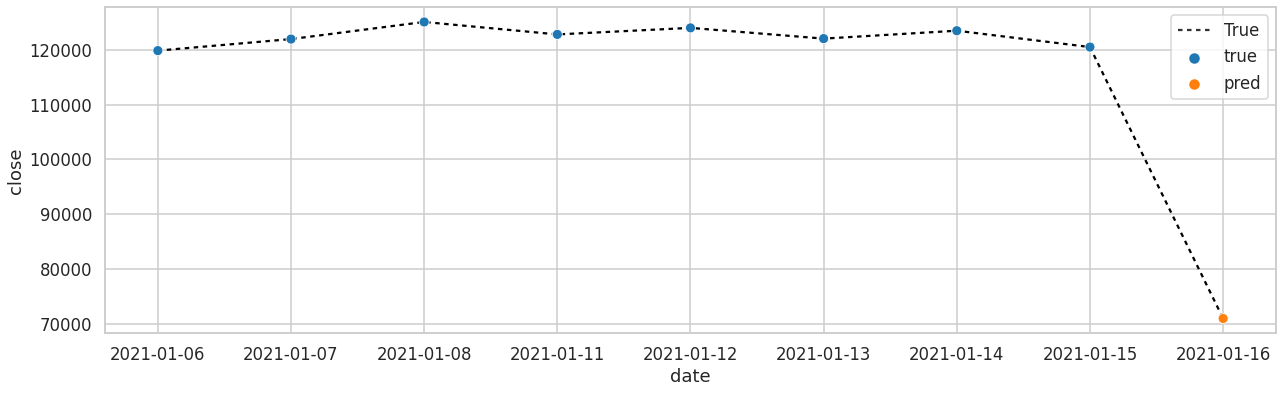

In [103]:
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(21, 6))
sns.scatterplot(data=dados_graph, x="date", y="close", hue='type', s=10**2, zorder=2)
sns.lineplot(data=dados_graph, x="date", y="close", color="black", style=True, dashes=[(2,2)], zorder=1)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [83]:
kill_endpoint(config)

({'ResponseMetadata': {'RequestId': '74c84e9d-356a-4696-b926-e6291d51c0bb',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amzn-requestid': '74c84e9d-356a-4696-b926-e6291d51c0bb',
    'content-type': 'application/x-amz-json-1.1',
    'content-length': '0',
    'date': 'Sun, 17 Jan 2021 18:43:54 GMT'},
   'RetryAttempts': 0}},
 {'ResponseMetadata': {'RequestId': 'd4fd94a7-123b-4657-b5a3-3520c3cb71b8',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amzn-requestid': 'd4fd94a7-123b-4657-b5a3-3520c3cb71b8',
    'content-type': 'application/x-amz-json-1.1',
    'content-length': '0',
    'date': 'Sun, 17 Jan 2021 18:43:55 GMT'},
   'RetryAttempts': 0}},
 {'ResponseMetadata': {'RequestId': 'be0e8b14-81ec-4511-93e4-fd3e53181c62',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amzn-requestid': 'be0e8b14-81ec-4511-93e4-fd3e53181c62',
    'content-type': 'application/x-amz-json-1.1',
    'content-length': '0',
    'date': 'Sun, 17 Jan 2021 18:43:55 GMT'},
   'RetryAttempts': 0}})